# Business Problem





In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [2]:
shots_df = pd.read_csv('shots_2022.csv')
buffalo_df = pd.read_csv('BUF.csv')
buffalo_player_stats = pd.read_csv('buf_player_stats.csv')
boston_player_stats = pd.read_csv('BOS.csv')
boston_df = pd.read_csv('BOS_team_stats.csv')

# Business Understanding


The Buffalo Sabres want to know how they can improve.  First we will look into what areas they need to improve on, and then dive deeper into what suggestions we can make.

The Sabres allow just as many goals as they score so focus should be minimizing the number of goals scored against them.

# Data Clean Up

I only want to focus on the most current season, the 2022 season.  Usually the more data the better, however we do not want to include players that are not on either team anymore. 

In [3]:
buffalo_2022 = buffalo_df[buffalo_df['season'] == 2022]

In [4]:
boston_df['gameId'] = boston_df['gameId'].astype(str)
boston_2022 = boston_df[boston_df['gameId'].str[:4] == '2022']

Both boston and buffalo have their own dfs that focus on the current (2022) season

In [5]:
combined_2022_df = pd.concat([boston_2022, buffalo_2022])

In [6]:
combined_2022_df.isna().sum().sum()

340

After removing the season column (we know its all 2022) there is no more missing values

In [7]:
combined_2022_df.isna().sum().sum()

340

In [8]:
combined_2022_df.drop("season", axis=1, inplace=True)

In [9]:
combined_2022_df.isna().sum().sum()

0

Now that the seasons column has been removed (we know its all the 2022 season now) there are no missing values.

# EDA

I want to compare Buffalo's total "goalsFor" and the total  "goalsAgainst" to that of Bostons.

In [10]:
situation_all_df = combined_2022_df[combined_2022_df['situation'] == 'all']
team_goals = situation_all_df.groupby('team').sum()[['goalsFor', 'goalsAgainst']]
print(team_goals)

      goalsFor  goalsAgainst
team                        
BOS      254.0         147.0
BUF      247.0         247.0


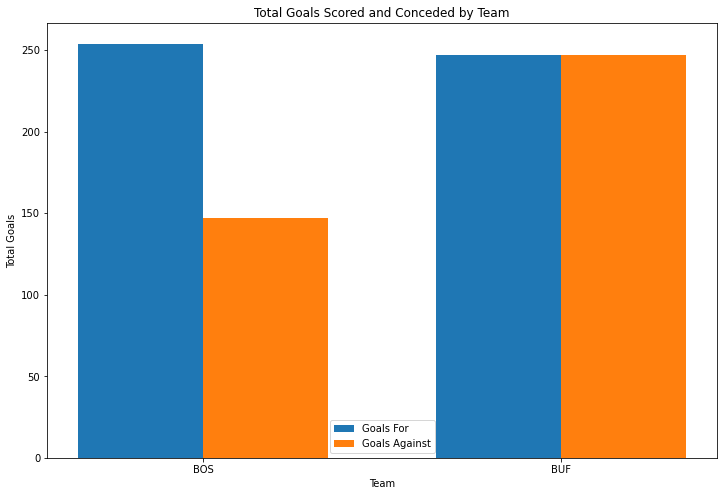

In [11]:
# Group the resulting DataFrame by the 'team' column, and sum the 'goalsFor' and 'goalsAgainst' columns within each group
team_goals = situation_all_df.groupby('team').sum()[['goalsFor', 'goalsAgainst']]

# Get the list of team names and the number of teams
team_names = list(team_goals.index)
num_teams = len(team_names)

# Create a numpy array for the goalsFor and goalsAgainst data
goals_for_data = np.array(team_goals['goalsFor'])
goals_against_data = np.array(team_goals['goalsAgainst'])

# Define the width of the bars
bar_width = 0.35

# Create a numpy array for the x-axis positions of the bars
x_positions = np.arange(num_teams)

# Set the figure size
fig, ax = plt.subplots(figsize=(12, 8))

# Create the bars for goalsFor and goalsAgainst for each team
ax.bar(x_positions - bar_width/2, goals_for_data, bar_width, label='Goals For')
ax.bar(x_positions + bar_width/2, goals_against_data, bar_width, label='Goals Against')

# Set the title and axis labels for the chart
plt.title('Total Goals Scored and Conceded by Team')
plt.xlabel('Team')
plt.ylabel('Total Goals')

# Set the tick labels for the x-axis
ax.set_xticks(x_positions)
ax.set_xticklabels(team_names)

# Add a legend for the bars
ax.legend()

# Show the chart
plt.show()

Looking at this, we can see that Boston (a serious Stanley Cup contender) scores about 100 more goals than they let in.  Buffalo on the other hand is dead even, 247 "goalsFor", and 247 "goalsAgainst". Also, Buffalo has a total "goalsFor" that is very similar to Boston's. This tells me that Buffalo has an offense that is on par with one of the best teams in the league, but their defense is far behind.

Now we will try to explain why Boston's defense is letting in so few goals compared to Buffalo.

# Defense Analysis

I want to compare the defense for different situations for both teams to focus in on why why Boston allows so many fewer goals

Situation percentages for each team:
situation  4on5  5on4  5on5    all  other
team                                     
BOS        21.1   3.4  64.6  100.0   10.9
BUF        19.0   2.0  66.8  100.0   12.1


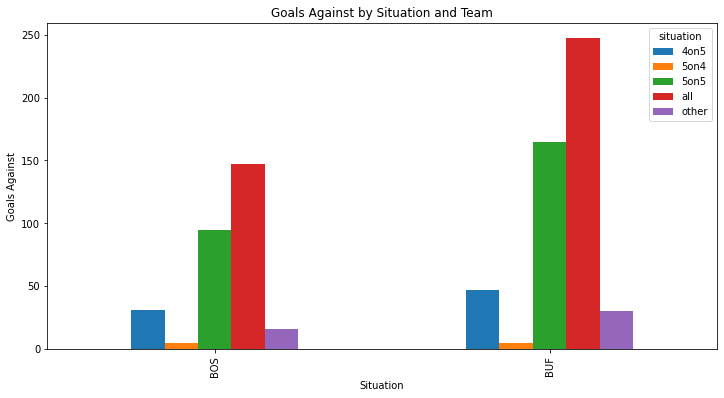

In [12]:
# Group the data by team and situation and get the sum of goalsAgainst
team_situation_goals = combined_2022_df.groupby(['team', 'situation']).sum()['goalsAgainst']

# Reshape the data to a wide format
team_situation_goals = team_situation_goals.unstack()

# Calculate the total goalsAgainst for each team
total_goals = team_situation_goals.sum(axis=1)

# Calculate the percentage of each situation's goalsAgainst out of the team's total goalsAgainst
situation_percentages = (team_situation_goals.div(total_goals, axis=0) * 100 * 2).round(1)

# Print the list of percentages for each situation
print("Situation percentages for each team:")
print(situation_percentages)

# Plot the data
team_situation_goals.plot(kind='bar', figsize=(12, 6))

# Set the plot title and labels
plt.title('Goals Against by Situation and Team')
plt.xlabel('Situation')
plt.ylabel('Goals Against')

# Show the plot
plt.show()

Percentages for both teams are close to each other for percentages of goals against in each situation. This indicates that buffalo allows too many goals all together, rather than just being particularly bad in one situation.  Next we can look into what features correlate to allowing a goal for buffalo's complete goalsAgainst total.

# Buffalo's goalsAgainst most relevant features

In [13]:
# Drop columns that contain 'flurry' or 'Flurry' in their names
buffalo_2022_filtered = buffalo_2022.drop(columns=[col for col in buffalo_2022.columns if 'flurry' in col.lower()])

# Filter the dataframe to only include rows where situation is "all"
buffalo_2022_filtered = buffalo_2022_filtered[buffalo_2022_filtered['situation'] == 'all']

# Calculate the correlation between each column and goalsAgainst
correlations = buffalo_2022_filtered.corr()['goalsAgainst']

# Get the top 12 correlations (excluding the correlation with goalsAgainst itself)
top_correlations = correlations.nlargest(13)[1:]

# Print the top 12 correlations
print(top_correlations)

highDangerGoalsAgainst                 0.672946
mediumDangerGoalsAgainst               0.595512
scoreAdjustedTotalShotCreditAgainst    0.466992
scoreVenueAdjustedxGoalsAgainst        0.393520
totalShotCreditAgainst                 0.384837
highDangerxGoalsAgainst                0.354096
lowDangerGoalsAgainst                  0.345214
reboundGoalsAgainst                    0.320879
xGoalsAgainst                          0.315013
highDangerShotsAgainst                 0.258818
playStoppedAgainst                     0.187315
gameId                                 0.168217
Name: goalsAgainst, dtype: float64


We can see that highDangerGoalsAgainst and mediumDangerGoalsAgainst are the top two correlated features to goalsAgainst.  This indicates that Buffalo is allowing teams to get to these areas to easily.  Next let's compare this list of features to the features that are relevant to Boston (cup contender) being scored on.

# Boston's goalsAgainst most relevant features

In [14]:
# Drop columns that contain 'flurry' or 'Flurry' in their names
boston_2022_filtered = boston_2022.drop(columns=[col for col in buffalo_2022.columns if 'flurry' in col.lower()])

# Filter the dataframe to only include rows where situation is "all"
boston_2022_filtered = boston_2022_filtered[boston_2022_filtered['situation'] == 'all']

# Calculate the correlation between each column and goalsAgainst
correlations = boston_2022_filtered.corr()['goalsAgainst']

# Get the top 12 correlations (excluding the correlation with goalsAgainst itself)
top_correlations = correlations.nlargest(13)[1:]

# Print the top 12 correlations
print(top_correlations)

mediumDangerGoalsAgainst               0.623421
highDangerGoalsAgainst                 0.572474
scoreAdjustedTotalShotCreditAgainst    0.520825
totalShotCreditAgainst                 0.500354
scoreVenueAdjustedxGoalsAgainst        0.474769
xGoalsAgainst                          0.458834
mediumDangerShotsAgainst               0.452626
lowDangerGoalsAgainst                  0.436365
mediumDangerxGoalsAgainst              0.436138
reboundGoalsAgainst                    0.393949
highDangerShotsAgainst                 0.359798
playContinuedInZoneFor                 0.341447
Name: goalsAgainst, dtype: float64


We see a few similar features here.  However one thing we should note here is that highDangerGoalsAgainst for Boston is lower than for Buffalo.  To me this means that Boston is doing a better job of keeping shooters out of the high danger areas.  Boston's high danger goalsAgainst are .10 lower than Buffalo.

In [15]:
situation_all_df

,team,name,gameId,playerTeam,opposingTeam,home_or_away,gameDate,position,situation,xGoalsPercentage,...,scoreAdjustedShotsAttemptsAgainst,unblockedShotAttemptsAgainst,scoreAdjustedUnblockedShotAttemptsAgainst,dZoneGiveawaysAgainst,xGoalsFromxReboundsOfShotsAgainst,xGoalsFromActualReboundsOfShotsAgainst,reboundxGoalsAgainst,totalShotCreditAgainst,scoreAdjustedTotalShotCreditAgainst,scoreFlurryAdjustedTotalShotCreditAgainst
1,BOS,BOS,2022020005,BOS,WSH,AWAY,20221012,Team Level,all,0.5323,...,62.005,46.0,43.172,7.0,0.538,0.212,0.212,3.082,2.937,2.801
6,BOS,BOS,2022020027,BOS,ARI,HOME,20221015,Team Level,all,0.6985,...,44.967,33.0,32.216,3.0,0.381,0.225,0.225,2.545,2.545,2.530
11,BOS,BOS,2022020041,BOS,FLA,HOME,20221017,Team Level,all,0.5490,...,77.245,56.0,55.373,0.0,0.867,1.571,1.571,3.100,3.119,3.022
16,BOS,BOS,2022020049,BOS,OTT,AWAY,20221018,Team Level,all,0.4741,...,62.238,47.0,48.161,6.0,0.557,0.509,0.509,3.989,4.007,3.965
21,BOS,BOS,2022020059,BOS,ANA,HOME,20221020,Team Level,all,0.6459,...,49.917,39.0,39.564,3.0,0.377,0.010,0.010,1.910,1.962,1.925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5691,BUF,BUF,2022021025,BUF,DAL,HOME,20230309,Team Level,all,0.2916,...,75.615,58.0,65.151,1.0,0.710,0.036,0.036,4.969,5.506,5.404
5696,BUF,BUF,2022021040,BUF,NYR,HOME,20230311,Team Level,all,0.5431,...,53.127,38.0,38.666,3.0,0.513,0.201,0.201,2.519,2.580,2.378
5701,BUF,BUF,2022021061,BUF,TOR,AWAY,20230313,Team Level,all,0.6560,...,47.833,39.0,38.148,11.0,0.385,0.266,0.266,1.970,1.911,1.869
5706,BUF,BUF,2022021076,BUF,WSH,AWAY,20230315,Team Level,all,0.4239,...,64.443,50.0,46.268,11.0,0.619,0.968,0.968,3.194,2.987,2.931


We are now looking into what the difference in goals is for Boston and Buffalo when beiong scored on from a high danger areas.

In [16]:
# Filter the dataframe to only include high danger goals against
high_danger_df = situation_all_df[situation_all_df['situation'] == 'all'][['team', 'goalsAgainst', 'highDangerGoalsAgainst']]

# Group the dataframe by team and sum the high danger goals against
team_high_danger_df = high_danger_df.groupby('team').sum()

# Print the resulting dataframe
print(team_high_danger_df)

      goalsAgainst  highDangerGoalsAgainst
team                                      
BOS          147.0                    51.0
BUF          247.0                    81.0


Buffalo allows 30 more goals from high danger areas.  When games can be won by one or two goals this can be a serious problem.  Buffalo is one of the top scoring teams in the league but allows so many goals.

In [17]:
shots_df

,shotID,arenaAdjustedShotDistance,arenaAdjustedXCord,arenaAdjustedXCordABS,arenaAdjustedYCord,arenaAdjustedYCordAbs,averageRestDifference,awayEmptyNet,awayPenalty1Length,awayPenalty1TimeLeft,...,xCordAdjusted,xFroze,xGoal,xPlayContinuedInZone,xPlayContinuedOutsideZone,xPlayStopped,xRebound,xShotWasOnGoal,yCord,yCordAdjusted
0,0,43.0,47.0,47.0,8.0,8.0,0.000000,0,0,0,...,44,0.214393,0.026009,0.398742,0.300830,0.022987,0.037040,0.710473,8,8
1,1,51.0,45.0,45.0,26.0,26.0,0.000000,0,0,0,...,44,0.186673,0.007774,0.455486,0.294453,0.020666,0.034948,0.667152,27,27
2,2,59.0,-31.0,31.0,8.0,8.0,0.000000,0,0,0,...,33,0.256798,0.046070,0.358080,0.259696,0.027936,0.051420,0.644651,8,-8
3,3,14.0,-76.0,76.0,-4.0,4.0,0.000000,0,0,0,...,74,0.172590,0.296800,0.230564,0.183049,0.024885,0.092112,0.898032,-5,5
4,4,14.0,-82.0,82.0,12.0,12.0,0.000000,0,0,0,...,81,0.128260,0.057435,0.446106,0.286419,0.019556,0.062224,0.759405,15,-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95093,352,40.0,-58.0,58.0,-26.0,26.0,5.833333,1,0,0,...,60,0.149341,0.061693,0.457400,0.265860,0.024608,0.041097,0.740899,-24,24
95094,353,46.0,55.0,55.0,31.0,31.0,0.000000,1,0,0,...,55,0.039771,0.341653,0.280115,0.295717,0.021925,0.020818,0.441629,31,31
95095,354,72.0,-20.0,20.0,-20.0,20.0,0.000000,1,0,0,...,19,0.013367,0.467303,0.192696,0.293724,0.021852,0.011058,0.472695,-20,20
95096,355,60.0,29.0,29.0,-3.0,3.0,0.833333,1,0,0,...,30,0.008746,0.847586,0.065123,0.064332,0.007230,0.006983,0.746178,-3,-3


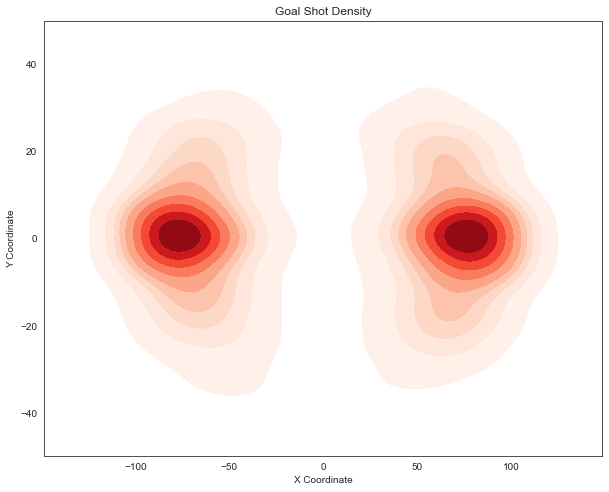

In [18]:
# Filter out the shots that didn't result in a goal
goal_shots = shots_df[shots_df["goal"] == 1]

# Set the style of the plot
sns.set_style("white")

# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the goal shots density map
sns.kdeplot(x=goal_shots["xCord"], y=goal_shots["yCord"], shade=True, cmap="Reds", ax=ax)
ax.set_title("Goal Shot Density")

# Set the plot title and axis labels
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")

# Show the plot
plt.show()

This code filters out the shots that resulted in a goal from a dataframe shots_df and stores the result in a new dataframe goal_shots. Then, it sets the style of the plot using Seaborn's set_style() function. A figure with one subplot is created, and a KDE plot of the goal shots' x and y coordinates is plotted using Seaborn's kdeplot() function with a colormap of "Reds" and a shading effect.

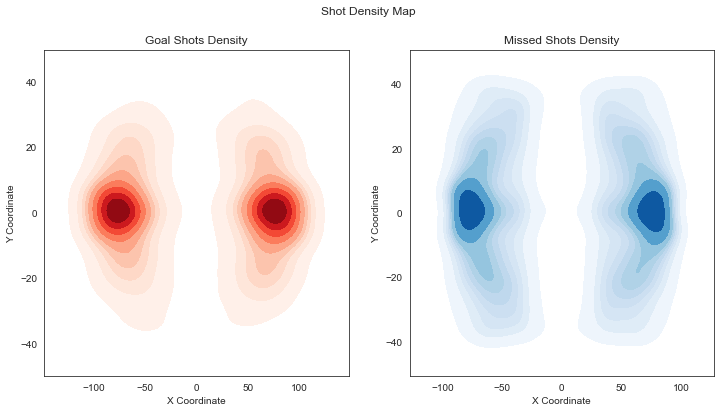

In [19]:
# Filter out the shots that didn't result in a goal
goal_shots = shots_df[shots_df["goal"] == 1]
missed_shots = shots_df[shots_df["goal"] == 0]

# Set the style of the plot
sns.set_style("white")

# Create a figure with two subplots
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

# Plot the goal shots density map in the first subplot
sns.kdeplot(x=goal_shots["xCord"], y=goal_shots["yCord"], shade=True, cmap="Reds", ax=axs[0])
axs[0].set_title("Goal Shots Density")

# Plot the missed shots density map in the second subplot
sns.kdeplot(x=missed_shots["xCord"], y=missed_shots["yCord"], shade=True, cmap="Blues", ax=axs[1])
axs[1].set_title("Missed Shots Density")

# Set the plot title and axis labels
fig.suptitle("Shot Density Map")
axs[0].set_xlabel("X Coordinate")
axs[0].set_ylabel("Y Coordinate")
axs[1].set_xlabel("X Coordinate")
axs[1].set_ylabel("Y Coordinate")

# Show the plot
plt.show()

This code is similar to the above code, but also returns the shots that did not result in a goal.  We can see that the further away the shot's yCord is from the net,  the less likely a goal will be scored.

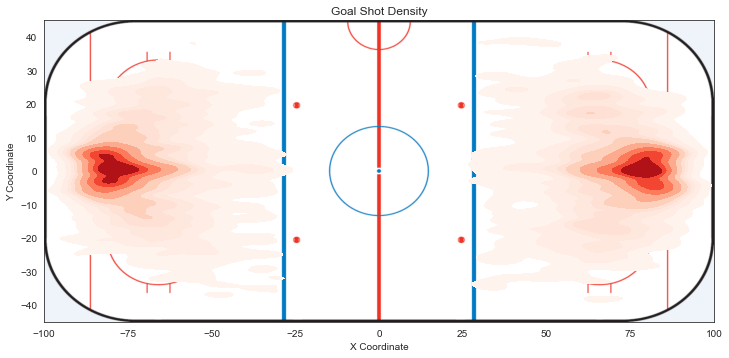

In [20]:
# Load the hockey rink image and resize it to match the plot dimensions
rink_img = mpimg.imread("hockeyRink.png")
rink_img_resized = cv2.resize(rink_img, (2000, 850))

# Filter out the shots that didn't result in a goal
goal_shots = shots_df[shots_df["goal"] == 1]

# Set the style of the plot
sns.set_style("white")

# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(12, 9))

# Set the x and y ranges of the plot
x_range = [-100, 100]
y_range = [-45, 45]

# Plot the hockey rink image in the background
ax.imshow(rink_img_resized, extent=[x_range[0], x_range[1], y_range[0], y_range[1]])

sns.kdeplot(x=goal_shots["xCord"], y=goal_shots["yCord"], shade=True, cmap="Reds", ax=ax, bw_adjust=.28)

# Set the plot title and axis labels
ax.set_title("Goal Shot Density")
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")

# Set the x and y limits of the plot
ax.set_xlim(x_range)
ax.set_ylim(y_range)

# Show the plot
plt.show()

This code loads an image of a hockey rink, resizes it to match the plot dimensions, and filters out the shots that did not result in a goal. Then, it creates a plot with the hockey rink image in the background and a kernel density estimate (KDE) plot of the goal shots' x and y coordinates in the foreground. The goal of the code is to visualize the density of shots that resulted in goals on a hockey rink.



From this density map we can see that as a shooter is pushed out towards the boards (towards -45 or 45) that shooters chance of scoring goes down.  This makes me curious to see what would happen if a random 25% of shots were moved out towards the boards by a few feet.

# Model predicting new shots that are moved 5 feet out towards the boards

First, we will isolate the shots that are in between -10 and 10 "yCord".  My plan is to show the effects of pushing a shooter out more towards the boards.

In [21]:
# Filter shots_df to only include shots with yCord between -10 and 10
yCord_shots = shots_df[(shots_df['yCord'] >= -10) & (shots_df['yCord'] <= 10)]

In [22]:
# Filter the columns that don't have "adjusted" or "Adjusted" in their column names
yCord_shots = yCord_shots.filter(regex='^(?!.*[aA]djusted).*$')

In [23]:
yCord_shots

,shotID,averageRestDifference,awayEmptyNet,awayPenalty1Length,awayPenalty1TimeLeft,awaySkatersOnIce,awayTeamCode,awayTeamGoals,defendingTeamAverageTimeOnIce,defendingTeamAverageTimeOnIceOfDefencemen,...,timeUntilNextEvent,xCord,xFroze,xGoal,xPlayContinuedInZone,xPlayContinuedOutsideZone,xPlayStopped,xRebound,xShotWasOnGoal,yCord
0,0,0.000000,0,0,0,5,SJS,0,23.000000,23.0,...,1,44,0.214393,0.026009,0.398742,0.300830,0.022987,0.037040,0.710473,8
2,2,0.000000,0,0,0,5,SJS,0,35.000000,35.0,...,2,-33,0.256798,0.046070,0.358080,0.259696,0.027936,0.051420,0.644651,8
3,3,0.000000,0,0,0,5,SJS,0,37.000000,37.0,...,0,-74,0.172590,0.296800,0.230564,0.183049,0.024885,0.092112,0.898032,-5
5,5,0.000000,0,0,0,5,SJS,0,36.000000,36.0,...,22,-68,0.088519,0.060461,0.464366,0.316184,0.026235,0.044235,0.401010,9
6,6,-5.800000,0,0,0,5,SJS,0,42.600000,46.5,...,25,72,0.083920,0.084009,0.454167,0.309893,0.022000,0.046011,0.536515,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95083,342,0.000000,0,120,12,4,CBJ,4,1.000000,1.0,...,2,66,0.216450,0.074031,0.416961,0.181989,0.035184,0.075386,0.869841,1
95084,343,0.000000,0,120,6,4,CBJ,4,7.000000,7.0,...,9,73,0.180888,0.122011,0.323506,0.277812,0.038504,0.057279,0.523065,5
95085,344,2.000000,0,0,0,5,CBJ,4,13.400000,16.0,...,2,77,0.099365,0.092506,0.455544,0.269046,0.029801,0.053737,0.558748,0
95090,349,-8.200000,0,0,0,5,CBJ,4,25.600000,33.0,...,0,79,0.132800,0.179593,0.356378,0.245688,0.021676,0.063865,0.891525,-2


In [24]:
# select columns with "x" or "X" in the column title, as well as the "yCord" column
x_cols = yCord_shots.filter(regex='^(yCord|[xX].*)$')

# create the new dataframe with only the selected columns
x_yCord_shots = yCord_shots[x_cols.columns]

# display the new dataframe
x_yCord_shots

,xCord,xFroze,xGoal,xPlayContinuedInZone,xPlayContinuedOutsideZone,xPlayStopped,xRebound,xShotWasOnGoal,yCord
0,44,0.214393,0.026009,0.398742,0.300830,0.022987,0.037040,0.710473,8
2,-33,0.256798,0.046070,0.358080,0.259696,0.027936,0.051420,0.644651,8
3,-74,0.172590,0.296800,0.230564,0.183049,0.024885,0.092112,0.898032,-5
5,-68,0.088519,0.060461,0.464366,0.316184,0.026235,0.044235,0.401010,9
6,72,0.083920,0.084009,0.454167,0.309893,0.022000,0.046011,0.536515,2
...,...,...,...,...,...,...,...,...,...
95083,66,0.216450,0.074031,0.416961,0.181989,0.035184,0.075386,0.869841,1
95084,73,0.180888,0.122011,0.323506,0.277812,0.038504,0.057279,0.523065,5
95085,77,0.099365,0.092506,0.455544,0.269046,0.029801,0.053737,0.558748,0
95090,79,0.132800,0.179593,0.356378,0.245688,0.021676,0.063865,0.891525,-2


We select columns from a dataframe yCord_shots based on whether their column name contains "x" or "X" or is equal to "yCord". The selected columns are stored in a new dataframe x_cols. Then, a new dataframe x_yCord_shots is created with only the selected columns from yCord_shots. Finally, the new dataframe x_yCord_shots is displayed. The goal of this code is to filter and select specific columns from a dataframe based on their column name.

In [25]:
# create a new column with the modified yCord values
x_yCord_shots['yCord_modified'] = x_yCord_shots['yCord'].apply(lambda x: x+5 if x >= 0 else x-5)

# select features and target
X = x_yCord_shots.drop(['xGoal'], axis=1) # exclude the 'goal' column
y = x_yCord_shots['xGoal']

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# fit a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# make predictions on the modified yCord values
X_modified = X.copy()
X_modified['yCord'] = x_yCord_shots['yCord_modified']
y_pred = model.predict(X_modified)

# calculate the number of shots predicted to be goals
num_predicted_goals = sum(y_pred >= 0.5)

print("Number of shots predicted to be goals with modified yCord values:", num_predicted_goals)

Number of shots predicted to be goals with modified yCord values: 760


<ipython-input-25-8d38935ad894>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_yCord_shots['yCord_modified'] = x_yCord_shots['yCord'].apply(lambda x: x+5 if x >= 0 else x-5)


This code is using a linear regression model to predict the number of goals scored based on the position of the shot on the hockey rink. It first modifies the position of the shots, then selects the features and target, splits the data into training and testing sets, fits the linear regression model, and finally makes predictions on the modified shot positions to calculate the number of shots predicted to be goals.

In [26]:
# create OLS regression summary
X_train = sm.add_constant(X_train) # add constant term to the model
model_OLS = sm.OLS(y_train, X_train).fit()
print(model_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                  xGoal   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 1.990e+06
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        14:10:07   Log-Likelihood:             1.2808e+05
No. Observations:               33208   AIC:                        -2.561e+05
Df Residuals:                   33198   BIC:                        -2.561e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

The R-squared value of 0.998 tells us that the other features in the dataset explain 99.8% of the variation in xGoal.

The coefficients show how much each feature affects xGoal. For example, a one-unit increase in xFroze would result in a 0.9996 decrease in xGoal.

The P-values show whether each feature is statistically significant in predicting xGoal. A p-value less than 0.05 is considered significant, and xShotWasOnGoal is highly significant with a p-value of 0.000.

The standard errors show how much the coefficients vary from sample to sample. Smaller standard errors indicate more precise coefficients.

The confidence intervals show the range within which the true coefficient value is expected to fall with 95% confidence. For example, the coefficient for xPlayStopped has a 95% confidence interval of -0.980 to -0.966, meaning that we can be 95% confident that the true effect of xPlayStopped on xGoal falls within that range.

